In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import time

from numpy import typing as npt


In [2]:
def one_hot(Y: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
    one_hot_Y = np.zeros((Y.size, 10))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y

x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
x = x.to_numpy()

y = np.array(list(map(int, y)))
y = one_hot(y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=44)


c:\Users\Anton\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


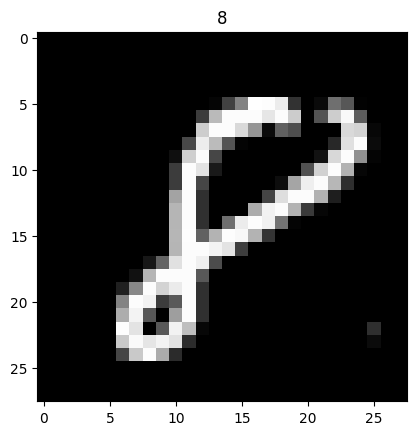

In [3]:
item_num = 1090


plt.imshow(x_train[item_num].reshape((28,28)), cmap='gray')
plt.title(f"{np.where(y_train[item_num] == 1)[0][0]}") 
plt.show()


In [4]:
class DeepNeuralNetwork():
    def __init__(
            self,
            sizes: list[int],
            epochs: int=10,
            batch_size:int=64,
            l_rate: float=0.01,
        ):
        self.sizes = sizes
        self.epochs = epochs
        self.batch_size = batch_size
        self.l_rate = l_rate

        self.params = self.initialization()

    def ReLU(
            self,
            x: npt.NDArray[np.float32], 
            derivative: bool=False
    ) -> np.ndarray:
        
        if derivative:
            return x > 0
        return np.maximum(x, 0)

    def softmax(
            self,
            x: npt.NDArray[np.float32],
            axis: int=-1,
    ) -> npt.NDArray[np.float32]:

        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=axis, keepdims=True)
        
    def initialization(self) -> dict[str, npt.NDArray[np.float32]]:

        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        output_layer=self.sizes[2]

        params = {
            'W1':np.random.randn(input_layer, hidden_1) * np.sqrt(1. / hidden_1),
            'b1': np.random.randn(1, hidden_1) * np.sqrt(1. / hidden_1),

            'W2':np.random.randn(hidden_1, output_layer) * np.sqrt(1. / output_layer),
            'b2': np.random.randn(1, output_layer) * np.sqrt(1. / hidden_1),
        }

        return params

    def forward_pass(
            self,
            x_train: npt.NDArray[np.float32],
    ) -> npt.NDArray[np.float32]:

        self.params['A0'] = x_train
        
        self.params['Z1'] = self.params['A0'] @ self.params["W1"]  + self.params['b1']
        self.params['A1'] = self.ReLU(self.params['Z1'])

        self.params['Z2'] = self.params['A1'] @ self.params["W2"]  + self.params['b2']
        self.params['A2'] = self.softmax(self.params['Z2'])

        return self.params['A2']

    def backward_pass(
            self,
            y_train: npt.NDArray[np.float32],
            output: npt.NDArray[np.float32],
    ) -> dict[str, npt.NDArray[np.float32]]:

        change_w = {}

        dZ2 = (output - y_train) 

        change_w['W2'] = (self.params['A1'].T) @ dZ2  * 1 / y_train.shape[0]
        change_w['b2'] =  np.sum(dZ2) * 1 / y_train.shape[0]

        dZ1 = 1 / y_train.shape[0] * dZ2 @ self.params['W2'].T * self.ReLU(self.params['Z1'], derivative=True)
        
        change_w['W1'] = self.params['A0'].T @ (dZ1)
        change_w['b1'] =  np.sum(dZ1)

        return change_w

    def update_params(self, change_w: dict[str, npt.NDArray[np.float32]]) -> None:

        self.params["W1"] -= self.l_rate * change_w['W1']
        self.params["W2"] -= self.l_rate * change_w['W2']
        self.params["b1"] -= self.l_rate * change_w['b1']
        self.params["b2"] -= self.l_rate * change_w['b2']

    def get_accuracy(
            self,
            predictions: npt.NDArray[np.float32],
            Y: npt.NDArray[np.float32]
    ) -> float:

        return np.sum(predictions == Y) / Y.size

    def train(
            self,
            x_train: npt.NDArray[np.float32],
            y_train: npt.NDArray[np.float32],
            x_val: npt.NDArray[np.float32],
            y_val: npt.NDArray[np.float32],
    ) -> None:

        start_time = time.time()
        num_batch_per_ephoc = x_train.shape[0] // self.batch_size

        if num_batch_per_ephoc != x_train.shape[0] / self.batch_size:
            num_batch_per_ephoc += 1
            
        for iteration in range(self.epochs):            
            output_accum = []
            for batch_number in range(num_batch_per_ephoc):

                x_curr = x_train[self.batch_size * batch_number : self.batch_size * (batch_number+1)]
                y_curr = y_train[self.batch_size * batch_number : self.batch_size * (batch_number+1)]

                output = self.forward_pass(x_curr)
                output_accum.extend(np.argmax(output, axis= 1))

                changes = self.backward_pass(y_curr, output)

                self.update_params(changes)
            
            accuracy = self.get_accuracy(np.array(output_accum), np.argmax(y_train, axis= 1))

            print(f'Epoch: {iteration+1}, Time Spent: {time.time() - start_time:.2f}s, Train accuracy: {accuracy:.3f}')

        preds_val = self.forward_pass(x_val)

        print(f"\nTest accuracy: {self.get_accuracy(np.argmax(preds_val , axis= 1), np.argmax(y_val, axis= 1)):.3f}")

In [5]:
dnn = DeepNeuralNetwork(sizes=[784, 300, 10], epochs=20, batch_size=64, l_rate=0.1)
dnn.train(x_train, y_train, x_val, y_val)


Epoch: 1, Time Spent: 2.30s, Train accuracy: 0.926
Epoch: 2, Time Spent: 4.60s, Train accuracy: 0.967
Epoch: 3, Time Spent: 6.80s, Train accuracy: 0.976
Epoch: 4, Time Spent: 9.06s, Train accuracy: 0.982
Epoch: 5, Time Spent: 11.32s, Train accuracy: 0.986
Epoch: 6, Time Spent: 13.96s, Train accuracy: 0.989
Epoch: 7, Time Spent: 16.34s, Train accuracy: 0.991
Epoch: 8, Time Spent: 18.69s, Train accuracy: 0.993
Epoch: 9, Time Spent: 20.99s, Train accuracy: 0.994
Epoch: 10, Time Spent: 23.54s, Train accuracy: 0.995
Epoch: 11, Time Spent: 25.97s, Train accuracy: 0.996
Epoch: 12, Time Spent: 28.39s, Train accuracy: 0.997
Epoch: 13, Time Spent: 30.69s, Train accuracy: 0.998
Epoch: 14, Time Spent: 33.12s, Train accuracy: 0.998
Epoch: 15, Time Spent: 35.45s, Train accuracy: 0.999
Epoch: 16, Time Spent: 37.75s, Train accuracy: 0.999
Epoch: 17, Time Spent: 40.21s, Train accuracy: 0.999
Epoch: 18, Time Spent: 42.62s, Train accuracy: 0.999
Epoch: 19, Time Spent: 44.98s, Train accuracy: 0.999
Epoch: